In [2]:
!pip install xgboost 

In [1]:
from xgboost import XGBClassifier


import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, classification_report, log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submit_df = pd.read_csv('sample_submission.csv')

In [3]:
submit_df

,1,0
0,2,0
1,4,0
2,5,0
3,6,0
4,8,0
...,...,...
994,1992,0
995,1993,0
996,1995,0
997,1997,0


In [97]:
train_df1 = train_df
test_df1  = test_df

train_df1['data1'] = train_df1['serum_sodium'] / int(train_df1['serum_sodium'].sum()) * 100
train_df1['data2'] = train_df1['creatinine_phosphokinase'] / (train_df1['platelets'] + train_df1['serum_creatinine'] + train_df1['serum_sodium'])
train_df1['data3'] = train_df1['ejection_fraction'] / train_df1['serum_sodium']

test_df1['data1'] = test_df1['serum_sodium'] / int(test_df1['serum_sodium'].sum()) * 100
test_df1['data2'] = test_df1['creatinine_phosphokinase'] / (test_df1['platelets'] + test_df1['serum_creatinine'] + test_df1['serum_sodium'])
test_df1['data3'] = test_df1['ejection_fraction'] / test_df1['serum_sodium']

In [98]:
train_df1.head(2)

,id,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,target,data1,data2,data3
0,0,56,1,5882,0,38,0,185315.0104,0.844417,134,1,0,10,1,0.097924,0.031717,0.283582
1,3,50,0,1767,1,35,0,371620.3666,0.837448,136,0,0,187,1,0.099385,0.004753,0.257353


In [99]:
train_df_plot = train_df1[['age', 'ejection_fraction', 'platelets', 'serum_creatinine', 
                          'serum_sodium', 'time', 'target']]

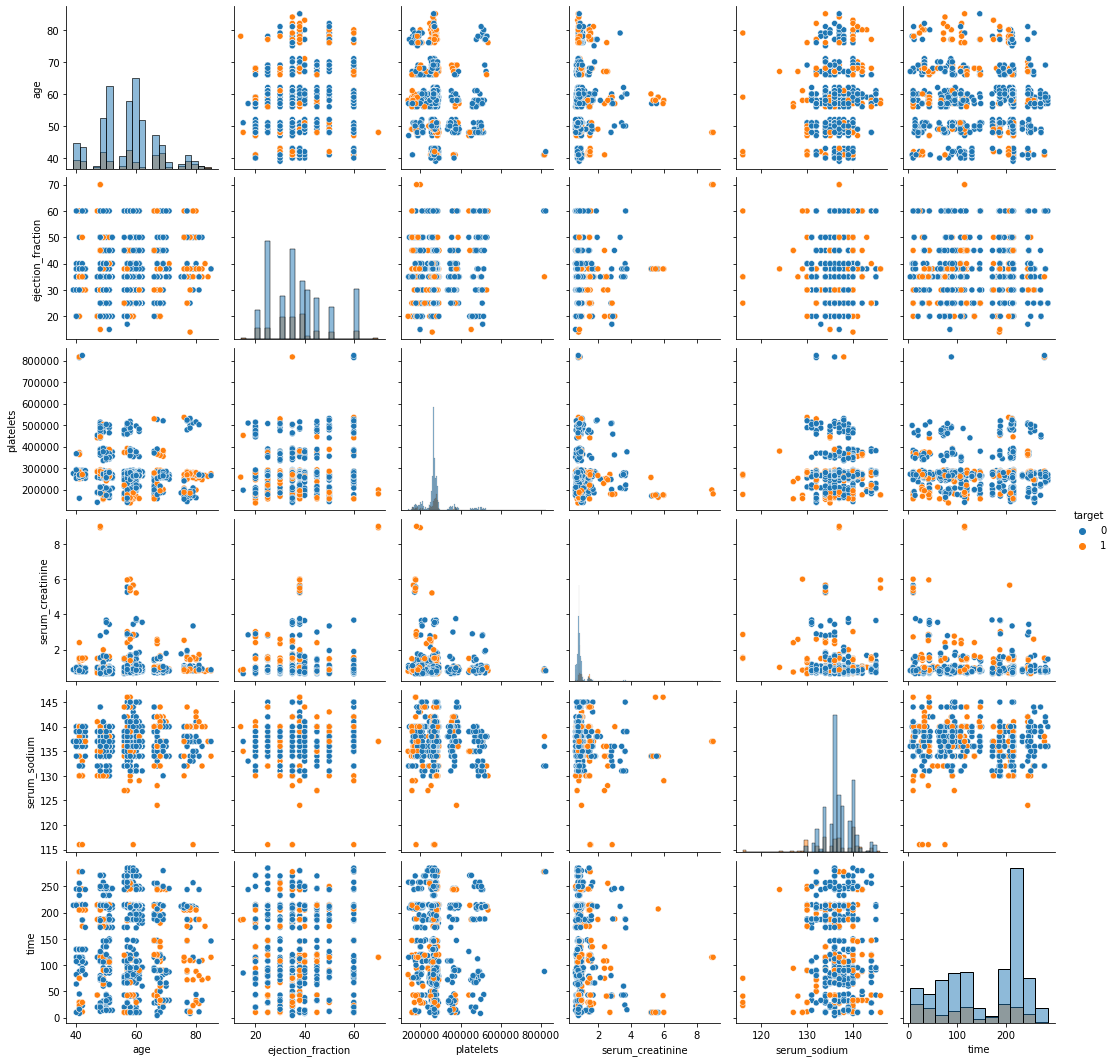

In [100]:
sns.pairplot(train_df_plot, hue="target", diag_kind='hist')

# 外れ値の置き換え

c:\users\81805\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


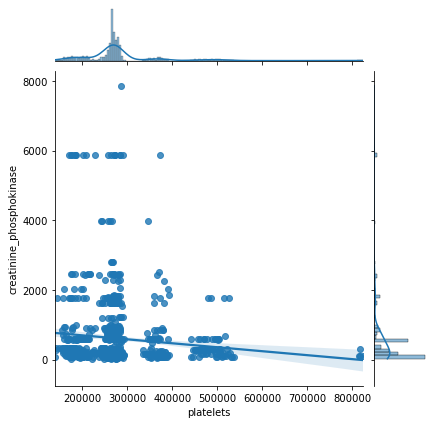

In [101]:
sns.jointplot('platelets', 'creatinine_phosphokinase', data=train_df1, kind="reg")

c:\users\81805\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


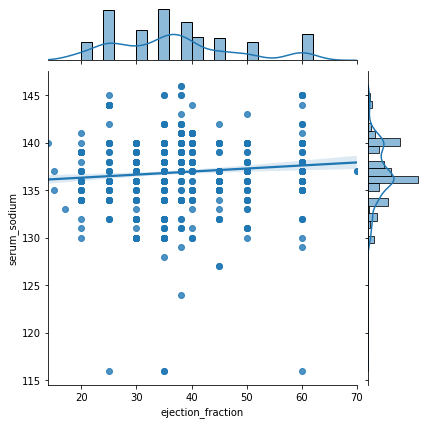

In [102]:
sns.jointplot('ejection_fraction', 'serum_sodium', data=train_df1, kind="reg")

In [103]:
train_df1.query('platelets > 800000')

,id,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,target,data1,data2,data3
78,150,41,1,292,1,60,0,817404.6356,0.908116,136,1,0,88,0,0.099385,0.000357,0.441176
131,256,41,1,96,1,60,0,814355.5574,0.809539,132,1,0,278,0,0.096462,0.000118,0.454545
780,1573,41,0,96,0,35,0,817402.9331,0.841704,138,0,0,278,1,0.100847,0.000117,0.253623
873,1731,42,1,96,1,60,0,824131.9167,0.801547,132,0,0,278,0,0.096462,0.000116,0.454545


In [104]:
train_df1.query('serum_sodium < 120')

,id,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,target,data1,data2,data3
671,1346,59,0,897,0,25,0,177765.2306,2.858986,116,1,0,41,1,0.08477,0.005043,0.215517
756,1530,79,1,936,1,60,1,272406.4061,1.555344,116,1,0,23,1,0.08477,0.003435,0.517241
978,1958,41,1,936,1,35,1,265797.6574,1.503617,116,1,0,75,1,0.08477,0.003520,0.301724
994,1986,42,0,936,1,35,1,270034.8414,1.518629,116,1,0,29,1,0.08477,0.003465,0.301724


In [105]:
print('platelets_median:               ', train_df1['platelets'].median())
print('creatinine_phosphokinase_median:', train_df1['creatinine_phosphokinase'].median())
print('serum_sodium:                   ', train_df1['serum_sodium'].median())

platelets_median:                267025.0547
creatinine_phosphokinase_median: 255.0
serum_sodium:                    136.5


In [108]:
# number of replace


median = [5000, 255, 136.5]
train_df1['platelets'] = np.where(train_df1['platelets'] >800000, median[0],train_df1['platelets'])
train_df1['creatinine_phosphokinase'] = np.where(train_df1['creatinine_phosphokinase'] > 1000, median[1],train_df1['creatinine_phosphokinase'])
train_df1['serum_sodium'] = np.where(train_df1['serum_sodium'] < 120, median[2],train_df1['serum_sodium'])

c:\users\81805\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


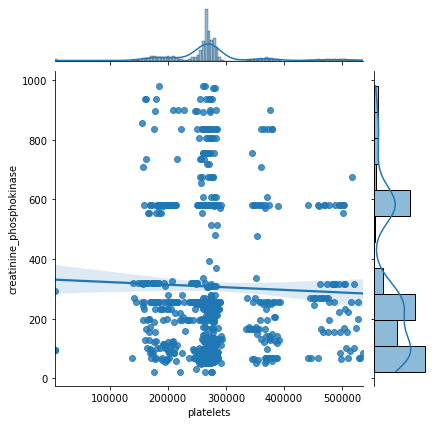

In [109]:
sns.jointplot('platelets', 'creatinine_phosphokinase', data=train_df1, kind="reg")

c:\users\81805\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


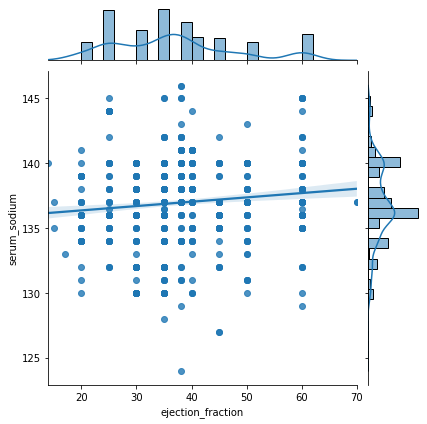

In [110]:
sns.jointplot('ejection_fraction', 'serum_sodium', data=train_df1, kind="reg")

c:\users\81805\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


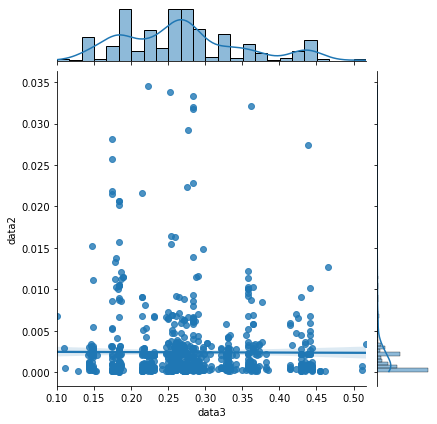

In [62]:
sns.jointplot('data3', 'data2', data=train_df1, kind="reg")

In [53]:
# 変更前(std)：creatinine_phosphokinase⇒971.937382、platelets⇒79543.675235

train_df1.describe()

,id,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,target,data1,data2,data3
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,999.734000,57.632000,0.41600,307.474000,0.270000,36.691000,0.237000,275076.947294,1.030258,136.923000,0.755000,0.25600,149.560000,0.198000,0.100000,0.002407,0.268093
std,578.002214,9.875328,0.49314,241.924039,0.444182,11.037089,0.425455,73811.569587,0.704616,3.139096,0.430302,0.43664,77.381072,0.398692,0.002489,0.004227,0.080262
min,0.000000,39.000000,0.00000,23.000000,0.000000,14.000000,0.000000,5000.000000,0.629178,124.000000,0.000000,0.00000,4.000000,0.000000,0.084770,0.000084,0.100000
25%,496.750000,50.000000,0.00000,93.000000,0.000000,30.000000,0.000000,255963.757000,0.798218,135.000000,1.000000,0.00000,84.500000,0.000000,0.098655,0.000335,0.214286
50%,1007.500000,58.000000,0.00000,254.000000,0.000000,35.000000,0.000000,266909.882150,0.844389,136.750000,1.000000,0.00000,185.000000,0.000000,0.099751,0.000949,0.261194
75%,1512.250000,61.000000,1.00000,582.000000,1.000000,40.000000,0.000000,279649.109975,0.956294,139.000000,1.000000,1.00000,213.000000,0.000000,0.101578,0.002258,0.300995
max,1998.000000,85.000000,1.00000,981.000000,1.000000,70.000000,1.000000,536460.291200,8.994597,146.000000,1.000000,1.00000,285.000000,1.000000,0.106693,0.034567,0.517241


In [87]:
# 説明変数⇒X、目的変数⇒Y

X = train_df1[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'time']]
Y = train_df1['target']
XT = test_df1[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'time']]

In [88]:

#パラメータを設定
params = {'objective':'binary:logistic',
          'max_depth':12,
          'eta': 0.1, 
          'min_child_weight':1.0,
          'gamma':0.9,
          'colsample_bytree':0.9,
          'subsample':0.9}


num_round = 60

logloss = []
accuracy = []

kf = KFold(n_splits=10, shuffle=True, random_state=32)
for train_index, valid_index in kf.split(X):
    x_train, x_valid = X.iloc[train_index], X.iloc[valid_index] 
    y_train, y_valid = Y.iloc[train_index], Y.iloc[valid_index]
    #データフレームをxgboostに適した形に変換
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    dtest = xgb.DMatrix(XT)
    #xgboostで学習
    evals_result = {}
    model = xgb.train(params, dtrain, num_round,evals=[(dtrain,'train'),(dvalid,'eval')], evals_result=evals_result,
                      early_stopping_rounds=120)

    valid_pred_proba = model.predict(dvalid)
    #loglossを求める
    score = log_loss(y_valid, valid_pred_proba)
    logloss.append(score)
    #accuracyを求める
    #valid_pred_probaは確率値なので0と1に変換
    valid_pred = np.where(valid_pred_proba >0.5,1,0)
    acc = accuracy_score(y_valid, valid_pred)
    accuracy.append(acc)

print(f'log_loss:{np.mean(logloss)}')
print(f'accuracy:{np.mean(accuracy)}')

[22:10:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.63579	eval-logloss:0.63781
[1]	train-logloss:0.58710	eval-logloss:0.60085
[2]	train-logloss:0.54444	eval-logloss:0.56972
[3]	train-logloss:0.50644	eval-logloss:0.53649
[4]	train-logloss:0.47258	eval-logloss:0.51105
[5]	train-logloss:0.44225	eval-logloss:0.48625
[6]	train-logloss:0.41458	eval-logloss:0.46252
[7]	train-logloss:0.39133	eval-logloss:0.45111
[8]	train-logloss:0.37091	eval-logloss:0.44175
[9]	train-logloss:0.35165	eval-logloss:0.42778
[10]	train-logloss:0.33383	eval-logloss:0.41174
[11]	train-logloss:0.31807	eval-logloss:0.40043
[12]	train-logloss:0.30405	eval-logloss:0.39353
[13]	train-logloss:0.29011	eval-logloss:0.38711
[14]	train-logloss:0.27677	e

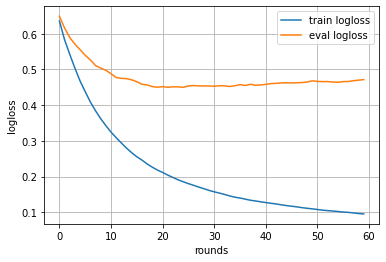

In [89]:
# 学習の課程を折れ線グラフとしてプロットする
train_metric = evals_result['train']['logloss']
plt.plot(train_metric, label='train logloss')
eval_metric = evals_result['eval']['logloss']
plt.plot(eval_metric, label='eval logloss')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('logloss')
plt.show()

In [90]:
#predictで予測
y_pred_proba = model.predict(dtest)
y_pred= np.where(y_pred_proba > 0.5,1,0)
y_pred

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [91]:
Submit = test_df.loc[:,["id"]]
Submit['pred'] = y_pred

In [92]:
Submit['pred'].value_counts()

0    864
1    136
Name: pred, dtype: int64

In [4]:
submit_df

,1,0
0,2,0
1,4,0
2,5,0
3,6,0
4,8,0
...,...,...
994,1992,0
995,1993,0
996,1995,0
997,1997,0


In [5]:
test_df

,id,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,1,67,1,56,0,60,0,255844.0310,0.824480,140,0,0,147
1,2,58,0,320,0,38,0,163434.8513,5.281481,134,0,0,207
2,4,67,1,737,0,60,0,255278.8436,0.841388,140,0,0,113
3,5,48,0,231,1,60,0,500149.7955,0.742807,139,1,1,215
4,6,59,0,320,0,35,0,245489.2530,1.082861,132,1,0,215
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1992,52,1,582,0,45,1,272303.4409,0.840646,136,1,0,209
996,1993,51,0,130,1,35,0,270252.4419,0.858651,136,0,0,186
997,1995,59,0,132,0,38,0,271631.9731,0.880883,141,1,0,33
998,1997,61,0,582,0,60,0,265879.0010,0.932744,139,1,0,207


In [93]:
Submit

,id,pred
0,1,0
1,2,1
2,4,0
3,5,0
4,6,0
...,...,...
995,1992,0
996,1993,0
997,1995,0
998,1997,0


In [94]:
Submit.to_csv("submit_36.csv", index=False, header=False)